## Jackson Davis k-Nearest-Neighbors, Cross-validation, and Parameter Tuning demo

This notebook serves as a demonstration of some python code I wrote to implement k-Nearest-Neighbors and parameter tuning.  There was a significant focus on documentation and unit testing here, as well as getting a good handle on higher-order functions, generators, and other basic python concepts.  The code is not optimized for speed, but rather for readability and ease of use, and uses only python primitive data structures (e.g. no arrays or dataframes) as well as a functional, non-OOP programming style.

The dataset used as a demonstration here is a popular Kaggle dataset for machine learning, the [Red Wine Quality dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009).  The dataset is included in the repo as `Datasets/winequality-red.csv`.

For more information on myself or for contact, see https://www.sevenhillsmt.com/jackson-portfolio

In [1]:
import random
from typing import List, Dict, Tuple, Callable
from copy import deepcopy
from math import sqrt
import numpy as np # Used for simple functions only, e.g. np.mean()
import matplotlib.pyplot as plt

After imports, the first thing we do is load up the dataset.  Because each dataset is structured somewhat differently, this function is not documented for reuse.

In [2]:
def load_data(file_name: str) -> tuple[list, list]:
    with open(file_name, "r") as f:
        header = f.readline().rstrip().split(",")
        data = []
        for line in f:
            datum = [float(value) for value in line.rstrip().split(",")]
            data.append(datum)
        random.shuffle(data)
    return data, header

In [3]:
random.seed(3)
data = load_data("Datasets\winequality-red.csv")[0]

In [4]:
data[0]

[8.0, 0.42, 0.17, 2.0, 0.073, 6.0, 18.0, 0.9972, 3.29, 0.61, 9.2, 6.0]

In [5]:
len(data)

1599

As we can see, the data is already loaded into a list of observations, with the target value as the final element of each observation, which is compatible with the code below.  The target value is a quality score from 0-10, and we will be using this as both a regression problem and a classification problem.

-------------------------

# Standardization

First a couple of simple functions to further process the data such that it is standardized.  This is a common preprocessing step for k-Nearest-Neighbors, as the algorithm is sensitive to the scale of the data.  We will be using the z-score standardization method, which is to subtract the mean and divide by the standard deviation for each feature.

<a id="z_score_standardize"></a>
## z_score_standardize

`z_score_standardize` is a function that takes a dataset and returns a new dataset where each feature has been standardized to have a mean of 0 and a standard deviation of 1.  This is useful for improving the performance of some machine learning algorithms, such as K Nearest Neighbors, that are sensitive to the scale of the features.  Standardizing the features ensures that each feature is treated equally by the algorithm.

* **data** `list[list]`: a list of observations, each of which is a list of values for each feature.  **There should be no target values in this dataset.**

**return** `list[list]`: the same observations, but with each feature standardized to have a mean of 0 and a standard deviation of 1

In [6]:
def z_score_standardize(data: list[list]) -> list[list]:
    data = deepcopy(data)
    for i in range(len(data[0])):
        column = [row[i] for row in data]
        mean = np.mean(column)
        std = np.std(column)
        for row in data:
            row[i] = (row[i] - mean) / std
    return data

In [7]:
test_data = [[0,0,0,0], [1,1,1,2], [2,2,2,6]]
test_z_score = z_score_standardize(test_data)
assert np.allclose(np.mean(test_z_score, axis=0), [0,0,0,0])
assert np.allclose(np.std(test_z_score, axis=0), [1,1,1,1])

test_data = np.random.rand(100, 4)
test_z_score = z_score_standardize(test_data)
assert len(test_z_score) == 100
assert np.allclose(np.mean(test_z_score, axis=0), [0,0,0,0])
assert np.allclose(np.std(test_z_score, axis=0), [1,1,1,1])

<a id="process_data_x_only"></a>
## process_data_x_only

`process_data_x_only` is a helper function that takes data in which the target value is the last value in each observation, separates the observation data from the target values, and runs a given process on the observations (without the target values) before recombining.  It could be taken a step further and include a `split` and `recombine` function, but the risk of drowning in documentation may be increased.

* **data** `list[list]`: a list of observations, each of which is a list of values for each feature.  **The target value is the last item in each observation.**
* **process** `callable`: a function that takes a dataset and returns a new, processed dataset

**return** `list[list]`: the same observations, but with a process run on the non-target portion of each observation

In [8]:
def process_data_x_only(data: list[list], process: callable) -> list[list]:
    data = deepcopy(data)
    
    data_x = [row[:-1] for row in data]
    data_y = [[row[-1]] for row in data]
    data_x = process(data_x)

    for i in range(len(data)):
        data[i] = data_x[i] + data_y[i]

    return data

In [9]:
test_data = [[1,1,1,1], [1,1,1,1], [1,1,1,1]]
test_processed = process_data_x_only(test_data, lambda x: [[0,0,0], [0,0,0], [0,0,0]])
assert test_processed == [[0,0,0,1], [0,0,0,1], [0,0,0,1]]
test_processed = process_data_x_only(test_data, lambda x: [[1,0,0], [0,1,0], [0,0,1]])
assert test_processed == [[1,0,0,1], [0,1,0,1], [0,0,1,1]]
test_processed = process_data_x_only(test_data, lambda x: [[1,1,0], [0,1,1], [1,0,1]])
assert test_processed == [[1,1,0,1], [0,1,1,1], [1,0,1,1]]

In [10]:
data = process_data_x_only(data, z_score_standardize)
print(data[0])

[-0.18364134481694747, -0.6023367688141634, -0.5185144220985399, -0.38227061366211557, -0.30746785242725816, -0.9443463560547672, -0.8656761636507785, 0.24026624565698693, -0.13679826698989317, -0.2841411376234579, -1.1479806048222734, 6.0]


---------------------------

# kNN algorithm

The functions below are the building blocks of a k-Nearest-Neighbors (kNN) algorithm, a simple and very common classificiation/regression algorithm.  The algorithm is very simple: given a set of observations with known target values, and a new observation with an unknown target value, find the k most similar observations in the dataset, and use their target values to predict the target value of the new observation.  The similarity metric used here is the Euclidean distance between the observations, but other metrics could be used as well.

<a id="euclidean_distance"></a>
## euclidean_distance

`euclidean_distance` calculates the Euclidean distance between two points in n-dimensional space according to the following formula:
$$d(x_1,x_2) = \sqrt{\sum^n_{i=1}(x_{1i} - x_{2i})^2}$$
In the [knn](#knn) algorithm, where we are searching for `K Nearest Neighbors`, we use this function as the metric that defines `nearest`.  For this use case, we do not need to find the *actual* distance, just the *relative* distance between two points, so we can omit the square root operation when calling this as part of K Nearest Neighbors to make the function a bit faster.

**Used by**: [kNN](#kNN)

* **x1** `list`: a list of values representing a point in n-dimensional space
* **x2** `list`: a list of values representing a second point in n-dimensional space
* **do_sqrt** `bool`: whether or not to take the square root of the squared distance when calculating

**return** `float`: the Euclidean distance between the two points (possibly squared)

In [11]:
def euclidean_distance(x1: list, x2: list, do_sqrt: bool = True) -> float:
    distance_squared = sum((x1_i - x2_i) ** 2 for x1_i, x2_i in zip(x1, x2))
    if do_sqrt:
        return sqrt(distance_squared)
    else:
        return distance_squared

In [12]:
assert euclidean_distance([0, 0], [1, 1]) == sqrt(2)
assert euclidean_distance([0, 0], [1, 1], do_sqrt=False) == 2
assert euclidean_distance([0, 0], [0, 0]) == 0
assert euclidean_distance([-1, 0], [1, 0]) == 2

<a id="knn_real_regression"></a>
## knn_real_regression

`knn_real_regression` is a function that processes the list of *real "y" values only* for the K points found via the [knn](#knn) algorithm and simply returns the mean of these values.  It is for the real-valued regression use case of KNN.  It probably could just be called "mean", but it serves as a semantic reminder of its function and a complement to the categorical use case.

**Used by**: [kNN](#kNN)

* **nearest** `list[float]`: a list of target values for the K Nearest Neighbors

**return** `float`: the mean of the target values

In [13]:
def knn_real_regression(nearest: list[float]) -> float:
    return np.mean(nearest)

In [14]:
test_data = [1,2,3]
assert knn_real_regression(test_data) == 2
test_data = [1,2,3,4]
assert knn_real_regression(test_data) == 2.5
test_data = [-1,-2,0,1,2]
assert knn_real_regression(test_data) == 0

<a id="knn_cat_classification"></a>
## knn_cat_classification

`knn_cat_classification` is a function that processes the list of *categorical "y" values only* for the K points found via the [knn](#knn) algorithm and returns the most frequent category value in the list.  It is for the categorical classification use case of KNN.  It could probably just be called "find_most_frequent", but it serves as a semantic reminder of its function and a complement to the regression use case.

**Used by**: [kNN](#kNN)

* **nearest** `list[str]`: a list of target classes for the K Nearest Neighbors

**return** `str`: the most frequent class in the list

In [15]:
def knn_cat_classification(nearest: list[str]) -> str:
    classes, counts = np.unique(nearest, return_counts=True)
    return classes[np.argmax(counts)]

In [16]:
test_data = [1,2,2]
assert knn_cat_classification(test_data) == 2
test_data = [1,2,3,3]
assert knn_cat_classification(test_data) == 3
test_data = ['blue','blue','green','red']
assert knn_cat_classification(test_data) == 'blue'

<a id="knn"></a>
## knn

`knn` is an implementation of the "K Nearest Neighbors" algorithm for classification and regression.  It takes a "knowledge base" dataset of observations and their target values, a new observation, and a value for K, and returns the predicted target value for the new observation.  The algorithm works by finding the K observations *nearest* to the new observation in the knowledge base and then using the target values of those K observations to predict the target value of the new observation.  For regression, the predicted target value is the mean of the K target values.  For classification, the predicted target value is the most frequent target value in the K target values.

**Used by**: 
**Uses**: [euclidean_distance](#euclidean_distance), [knn_real_regression](#knn_real_regression), [knn_cat_classification](#knn_cat_classification)

* **dataset** `list[list]`: a list of observations, each of which is a list of values for each dimension.  **The target value is the last value in each dataset observation.**
* **query_point** `list`: a list representing a single observation with no target value.  **len(query_point) == len(dataset[0]) - 1 should be True**
* **processing** `callable`: a function that processes the list of target values for the K Nearest Neighbors and returns a single value.  For regression, this is [knn_real_regression](#knn_real_regression).  For classification, this is [knn_cat_classification](#knn_cat_classification).
* **k** `int`: the number of nearest neighbors to find and use for prediction

**return** `float|str`: the predicted target value for the new observation

In [17]:
def knn(dataset: list, query_point: list, processing: callable, k: int) -> float:
    distances = []
    for datapoint in dataset:
        distances.append((euclidean_distance(datapoint[:-1], query_point, do_sqrt=False), datapoint))
    distances.sort(key=lambda x: x[0])
    nearest_values = [item[1][-1] for item in distances[:k]]
    return processing(nearest_values)

In [18]:
test_data = [[0,0,0,'blue'], [1,1,1,'blue'], [2,2,2,'red']]
test_query = [1,1,1]
assert knn(test_data, test_query, knn_cat_classification, 2) == 'blue'

test_data = [[0,0,0,1], [1,1,1,1], [2,2,2,6], [3,3,3,0]]
test_query = [9,9,9]
assert knn(test_data, test_query, knn_real_regression, 4) == 2
assert knn(test_data, test_query, knn_cat_classification, 4) == 1

<a id="make_knn_func"></a>
## make_knn_func

`make_knn_func` is wrapper function that takes a dataset and a value for K and returns a K Nearest Neighbors ([knn](#knn)) function that can be used to make predictions for new observations.  This is useful for the [k_fold_evaluate](#k_fold_evaluate) function because it allows us to pass our KNN function in as a general 'classifier' function (with appropriate arguments) to be evaluated.

**Uses**: [knn](#knn)
**Used by**: [k_fold_evaluate](#k_fold_evaluate)

* **processing** `callable`: the method for processing the list of target values to return a single value.  For regression, this is [knn_real_regression](#knn_real_regression).  For classification, this is [knn_cat_classification](#knn_cat_classification).

**return** `callable`: a K Nearest Neighbors function that can be used to make predictions for new observations

In [19]:
def make_knn_func(processing: callable, k: int):
    def knn_func(dataset: list, query_point: list):
        return knn(dataset, query_point, processing, k)
    return knn_func

In [20]:
# Same tests as before
test_data = [[0,0,0,'blue'], [1,1,1,'blue'], [2,2,2,'red']]
test_query = [1,1,1]
knn_func = make_knn_func(knn_cat_classification, 2)
assert knn_func(test_data, test_query) == 'blue'

test_data = [[0,0,0,1], [1,1,1,1], [2,2,2,6], [3,3,3,0]]
test_query = [9,9,9]
knn_func = make_knn_func(knn_real_regression, 4)
assert knn_func(test_data, test_query) == 2
knn_func = make_knn_func(knn_cat_classification, 4)
assert knn_func(test_data, test_query) == 1

----------------------------

# Cross-validation

Now that kNN has been built, below is a simple implementation of k-fold cross-validation (yes, multiple uses of the letter 'k' is confusing), as well as some other simple performance validation tools.

<a id="k_fold_iterator"></a>
## k_fold_iterator

`k_fold_iterator` is a helper function that takes a dataset and a value for K and returns a generator that yields a list of K train/test folds for K-fold evaluation.  Each fold is a list of two lists: the first list is the training set and the second list is the test set.  **This function does not take specific target value location into account but assumes the target value is contained within each observation.**

**Used by**: [k_fold_evaluate](#k_fold_evaluate)

* **data** `list`: a list of observations
* **k** `int`: the number of folds to create
* **num_tests** `int`: length of the list of folds to return, if other than K.  This is useful for creating a single or small number of train/test folds, e.g. for parameter tuning.

**yield** `Tuple[list[list], list[list]]`: the train and test sets for each fold

In [21]:
def k_fold_iterator(data:list, k: int = 10, num_tests: int = None):
    if num_tests is None:
        num_tests = k
    random.shuffle(data)

    for i in range(num_tests):
        test = data[i*len(data)//k : (i+1)*len(data)//k]
        train = data[:i*len(data)//k] + data[(i+1)*len(data)//k:]
        yield train, test

In [22]:
fold_test_data = [[0,0,0,0], [1,1,1,2], [2,2,2,6]]
answers = [4,3,1]

for training, test in k_fold_iterator(fold_test_data, 3):
    assert knn(training, test[0][:-1], knn_real_regression, 2) in answers

<a id="mean_squared_error"></a>
## mean_squared_error

`mean_squared_error` is a function that calculates the mean squared error between two lists of real values.  It is used to evaluate the performance of a regression model by comparing the predicted target values to the actual target values.  The formula for MSE is:
$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$
where $y_i$ is the actual target value and $\hat{y}_i$ is the predicted target value.

**Used by**: [k_fold_evaluate](#k_fold_evaluate)

* **predicted** `list[float]`: a list of predicted target values
* **actual** `list[float]`: a list of actual target values

**return** `float`: the mean squared error between the lists of predicted and actual target values

In [23]:
def mean_squared_error(predicted: list, actual: list) -> float:
    return np.mean([(predicted_value - actual_value) ** 2 for predicted_value, actual_value in zip(predicted, actual)])

In [24]:
assert mean_squared_error([1,2,3], [1,2,3]) == 0
assert mean_squared_error([1,2,3,4], [3,2,1,4]) == 2
assert mean_squared_error([3,-1,4], [3,2,4]) == 3

<a id="simple_accuracy"></a>
## simple_accuracy

`simple_accuracy` is a function that compares a list of predicted target values to a list of actual target values and returns the percentage of correct predictions.  It is used to evaluate the performance of a classification model, and is best used when classes are relatively balanced within the dataset.

**Used by**: [k_fold_evaluate](#k_fold_evaluate)

* **predicted** `list[float]`: a list of predicted target values
* **actual** `list[float]`: a list of actual target values

**return** `float`: the percentage of correct predictions

In [25]:
def simple_accuracy(predicted: list, actual: list) -> float:
    return np.mean([predicted_value == actual_value for predicted_value, actual_value in zip(predicted, actual)])

In [26]:
assert simple_accuracy([1,2,3], [1,2,3]) == 1
assert simple_accuracy([1,2,3,4], [3,2,1,4]) == 0.5
assert simple_accuracy([3,-1,4], [3,2,4]) == 2/3

<a id="results_printer"></a>
## results_printer

`results_printer` is a printing function that accepts a list of results from [k_fold_evaluate](#k_fold_evaluate) and prints the results, split into 'training' and 'testing' evaluations, in a nicely formatted table.  It accepts a dictionary in the form `{'train': [], 'test': []}` where the lists are the results from each fold.  It also prints the mean and std of the results.

**Used by**: [k_fold_evaluate](#k_fold_evaluate)

* **results** `dict`: a dictionary of results from [k_fold_evaluate](#k_fold_evaluate)
* **verbose** `bool`: whether or not to print the individual results for each fold

**no return (This function has side effects, i.e. the printing)**

In [27]:
def results_printer(results: dict, verbose: bool = True):
    if verbose:
        print("Fold\t  Train\t\t Test")
        for i in range(len(results["train"])): # same length as test
            print(f"{i+1}:\t  {format(results['train'][i], '.4f')} \t {format(results['test'][i], '.4f')}")
        print("-----")
    print(f"avg\t  {format(np.mean(results['train']), '.4f')} \t {format(np.mean(results['test']), '.4f')}")
    print(f"std\t  {format(np.std(results['train']), '.4f')} \t {format(np.std(results['test']), '.4f')}")


<a id="classify"></a>
## classify

`classify` is an intermediary function that takes a set of training data, a set of test data, and a classifier function and returns the results of the classifier function on the training and test data.  It is used by [k_fold_evaluate](#k_fold_evaluate) to evaluate the performance of a classifier function on a set of folds.

**Used by**: [k_fold_evaluate](#k_fold_evaluate)

* **train_data** `list[list]`: a list of training observations.  **The target value is the last value in each observation.**
* **test_data** `list[list]`: a list of testing observations.  **Test data should also have the target value as the last element in each observation.  If none is available, I guess you have to put in a dummy value or everything just falls right apart.**
* **classifier** `callable`: a classifier function that takes a dataset and an observation and returns a predicted target value

**return** `list`: a list of predicted target values for the observations in the test data

In [28]:
def classify(train_data: list[list], test_data: list[list], classifier) -> list:
    predicted = []
    for test_point in test_data:
        predicted.append(classifier(train_data, test_point[:-1]))
    return predicted

<a id="baseline_regression"></a>
## baseline_regression

`baseline_regression` is a simple 'regression' function that takes a training dataset and returns the mean of the target values in the dataset as the prediction for the target value of each observation in the test set.  It is used as the baseline model for comparison with the other regression models.

**Used by**: [k_fold_evaluate](#k_fold_evaluate)

* **train_data** `list[list]`: a list of training observations.  **The target value is the last value in each observation.**
* **test_point** `list`: a query point to be 'classified' (regressed??).  **This parameter is unused, but included for compatibility**

**return** `list`: a list of predicted target values for the observations in the test data

In [29]:
def baseline_regression(train_data: list[list], test_point: list) -> float:
    return np.mean([train_point[-1] for train_point in train_data])

In [30]:
test_data = [[0,0,0,1], [1,1,1,1], [2,2,2,2], [3,3,3,2]]
test_query = [1,2,3,4]
assert baseline_regression(test_data, test_query) == 1.5
test_data = [[9,1], [9,2], [9,3], [9,4]]
test_query = [12,16]
assert baseline_regression(test_data, test_query) == 2.5
test_data = [[1,2], [2,2], [3,4], [4,4]]
test_query = ['gibberish']
assert baseline_regression(test_data, test_query) == 3

<a id="baseline_classification"></a>
## baseline_classification

`baseline_classification` is a simple 'classification' function that takes a training dataset and returns the most frequent target value in the dataset as the prediction for the target value of each observation in the test set.  It is used as the baseline model for comparison with the other classification models.

**Used by**: [k_fold_evaluate](#k_fold_evaluate)

* **train_data** `list[list]`: a list of training observations.  **The target value is the last value in each observation.**
* **test_point** `list`: a query point to be 'classified'.  **This parameter is unused, but included for compatibility**

**return** `list`: a list of predicted target values for the observations in the test data

In [31]:
def baseline_classification(train_data: list[list], test_point: list) -> str:
    classes, counts = np.unique([train_point[-1] for train_point in train_data], return_counts=True)
    return classes[np.argmax(counts)]

In [32]:
test_data = [[0,0,0,1], [1,1,1,1], [2,2,2,2], [3,3,3,3]]
test_query = [1,2,3,4]
assert baseline_classification(test_data, test_query) == 1
test_data = [[9,'cat'], [6,'cat'], [12,'dog']]
test_query = [12,16]
assert baseline_classification(test_data, test_query) == 'cat'
test_data = [[1,2], [2,3], [3,4], [4,4]]
test_query = ['gibberish']
assert baseline_classification(test_data, test_query) == 4

<a id="k_fold_evaluate"></a>
## k_fold_evaluate

`k_fold_evaluate` is a pipeline function for evaluating the performance of classifiers on a dataset using k-fold cross validation.  It takes a set of data, splits it into k train-test folds for evaluation, and passes the data into the given classifier function. It then evaluates the results with a given evaluation metric.  The function also optionally prints the results of the evaluation using [results_printer](#results_printer).

**Uses**: [iterate_folds](#iterate_folds), [classify](#classify), [results_printer](#results_printer)

* **data** `list`: the dataset to be split into folds and evaluated
* **k** `int`: the number of folds to split the data into
* **classifier** `callable`: a classifier function that takes a dataset and an observation and returns a predicted target value
* **evaluator** `callable`: an evaluation metric function that takes a list of predicted target values and a list of actual target values and returns a single value representing a generalization error metric
* **num_tests** `int`: the number of times to run the evaluation if you don't want to loop through all the folds (because it takes a long time).  Default None runs the evaluation on all the folds.
* **print_results** `bool`: whether or not to print the results of the evaluation
* **verbose** `bool`: whether or not to print the individual results for each fold


**return** `dict`: a dictionary of results from the evaluation in the form `{'avg_train': float, 'std_train': float, 'avg_test': float, 'std_test': float}`

In [33]:
def k_fold_evaluate(data: list, evaluator: callable, classifier: callable, *, k_folds: int = 10, num_tests: int = None, print_results:bool = True, verbose:bool = True) -> float:
    results = {'train': [], 'test': []}
    for training, test in k_fold_iterator(data, k=k_folds, num_tests=num_tests):
        results['train'].append(evaluator(classify(training, training, classifier), [train_point[-1] for train_point in training]))
        results['test'].append(evaluator(classify(training, test, classifier), [test_point[-1] for test_point in test]))
        
    if print_results:
        results_printer(results, verbose)
    
    returns = {'avg_train': np.mean(results['train']), 'std_train': np.std(results['train']),
               'avg_test': np.mean(results['test']), 'std_test': np.std(results['test'])}

    return returns

--------------------

# Hyperparameter Tuning

For our example, we want to choose the value of k that provides us with the most accuracy while still generalizing well to new data.  We will use the `k_fold_evaluate` function and some quick throwaway code to evaluate the performance of our kNN algorithm on a range of k values, and then choose the k value that provides the best performance.  This example uses a smaller dataset for efficiency, as the runtime of kNN is not exactly fast, and the larger the dataset (and the larger value of k), the longer it takes to run.

In [34]:
ks = list(range(1, 41, 2))
train_ks = []
test_ks = []
average_results = []
for k in ks:
    test_result = k_fold_evaluate(data[:800], mean_squared_error, make_knn_func(knn_real_regression, k), print_results=False, verbose=False)
    train_ks.append(test_result['avg_train'])
    test_ks.append(test_result['avg_test'])
    average_results.append((test_result['avg_test'], k))
average_results.sort(key=lambda x: x[0])
best_result = average_results[0]
print(f"Best k: {best_result[1]} with average MSE: {best_result[0]}")

Best k: 23 with average MSE: 0.4115146502835539


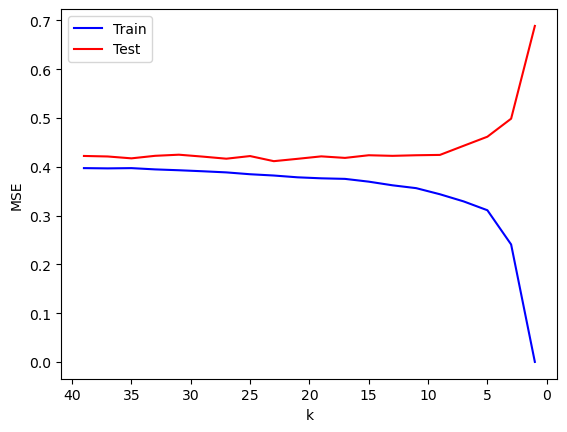

In [35]:
plt.plot(ks, train_ks, 'b', ks, test_ks, 'r')
plt.legend(['Train', 'Test'])
plt.xlabel('k')
plt.ylabel('MSE')
plt.gca().invert_xaxis()
plt.show()

----------------------------------

## Evaluation

Finally, having tuned our kNN algorithm, we can evaluate its performance with cross-fold validation.  First we make the kNN functions, both classification and regression, with k=17.  Then we compare the performance of the kNN algorithm to the baseline models, and print the results.

In [36]:
knn_cat = make_knn_func(knn_cat_classification, 17)
knn_reg = make_knn_func(knn_real_regression, 17)

In [37]:
print("Baseline classification:")
test_result = k_fold_evaluate(data, simple_accuracy, baseline_classification)

Baseline classification:
Fold	  Train		 Test
1:	  0.4299 	 0.3899
2:	  0.4295 	 0.3937
3:	  0.4281 	 0.4062
4:	  0.4218 	 0.4625
5:	  0.4274 	 0.4125
6:	  0.4218 	 0.4625
7:	  0.4274 	 0.4125
8:	  0.4225 	 0.4562
9:	  0.4267 	 0.4188
10:	  0.4239 	 0.4437
-----
avg	  0.4259 	 0.4259
std	  0.0029 	 0.0265


In [38]:
print("kNN classification:")
test_result = k_fold_evaluate(data, simple_accuracy, knn_cat)

kNN classification:
Fold	  Train		 Test
1:	  0.6438 	 0.5409
2:	  0.6567 	 0.4562
3:	  0.6268 	 0.6937
4:	  0.6379 	 0.6250
5:	  0.6421 	 0.5875
6:	  0.6407 	 0.6312
7:	  0.6324 	 0.6188
8:	  0.6379 	 0.6125
9:	  0.6567 	 0.5625
10:	  0.6442 	 0.5375
-----
avg	  0.6419 	 0.5866
std	  0.0089 	 0.0622


In [39]:
print("Baseline regression:")
test_result = k_fold_evaluate(data, mean_squared_error, baseline_regression)

Baseline regression:
Fold	  Train		 Test
1:	  0.6416 	 0.7438
2:	  0.6573 	 0.6023
3:	  0.6669 	 0.5152
4:	  0.6426 	 0.7346
5:	  0.6549 	 0.6238
6:	  0.6430 	 0.7306
7:	  0.6561 	 0.6147
8:	  0.6509 	 0.6596
9:	  0.6664 	 0.5211
10:	  0.6374 	 0.7811
-----
avg	  0.6517 	 0.6527
std	  0.0099 	 0.0887


In [40]:
print("kNN regression:")
test_result = k_fold_evaluate(data, mean_squared_error, knn_reg)

kNN regression:
Fold	  Train		 Test
1:	  0.3798 	 0.4748
2:	  0.3870 	 0.3993
3:	  0.3837 	 0.4438
4:	  0.3872 	 0.3983
5:	  0.3867 	 0.4299
6:	  0.3841 	 0.4270
7:	  0.3825 	 0.4546
8:	  0.3854 	 0.4293
9:	  0.3893 	 0.3652
10:	  0.3790 	 0.4974
-----
avg	  0.3845 	 0.4320
std	  0.0032 	 0.0367


As we can see, the kNN algorithm performs better than the baseline models, with a mean accuracy of 0.59 compared to 0.43 for the baseline classification model, and a mean squared error of 0.43 compared to 0.65 for the baseline regression model.  This is a good sign that our kNN algorithm is working well, and that our parameter tuning was successful.

------------------------------

As a final check, it's always nice to compare to an established library.  Below, we use the `KNeighborsRegressor` and `KNeighborsClassifier` classes from the `sklearn` library to compare the performance of our kNN algorithm to the performance of the `sklearn` implementation.  We can see that the performance of our kNN algorithm is very similar to the performance of the `sklearn` implementation, which is a good sign that our implementation is working well.  The sklearn library is, of course, much faster and more optimized than our implementation, and running it only takes a few lines of code, but this is how we learn!

In [44]:
import sklearn.neighbors

In [52]:
data_x = [row[:-1] for row in data]
data_y = [row[-1] for row in data]

In [53]:
model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=17)
model.fit(data_x[:1200], data_y[:1200])
predicted = model.predict(data_x[1200:])
print(f"Sklearn kNN regression: {mean_squared_error(predicted, data_y[1200:])}")

Sklearn kNN regression: 0.432907528336412


In [54]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=17)
model.fit(data_x[:1200], data_y[:1200])
predicted = model.predict(data_x[1200:])
print(f"Sklearn kNN classification: {simple_accuracy(predicted, data_y[1200:])}")

Sklearn kNN classification: 0.5789473684210527
